In [4]:
!pip install cvxpy


    


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import cvxpy as cp
from datetime import datetime, timedelta


In [6]:

# Список криптовалют для аналізу
tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'SOL-USD', 'DOGE-USD', 
           'MATIC-USD', 'DOT-USD', 'LTC-USD', 'SHIB-USD', 'AVAX-USD', 'UNI-USD', 'LINK-USD',
           'XLM-USD', 'AAVE-USD', 'TRX-USD', 'ALGO-USD', 'FTM-USD', 'EGLD-USD']

# Завантаження даних за останні 3 роки
end_date = datetime.today()
start_date = end_date - timedelta(days=1095)
data = {}

for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))[['Close', 'Volume']]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
# Нормалізація та підготовка даних
look_back = 60
scalers = {}
X_train, y_train, X_test, y_test = {}, {}, {}, {}

for ticker in tickers:
    df = data[ticker].dropna()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    scalers[ticker] = scaler

    # Формування набору даних для LSTM
    def create_dataset(dataset, look_back=60):
        X, y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:i+look_back])
            y.append(dataset[i + look_back, 0])  # Прогнозуємо 'Close'
        return np.array(X), np.array(y)

    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    X_train[ticker], y_train[ticker] = create_dataset(train_data, look_back)
    X_test[ticker], y_test[ticker] = create_dataset(test_data, look_back)


In [8]:
# Навчання моделей LSTM для кожної криптовалюти
models = {}

for ticker in tickers:
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 2)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Навчання моделі
    model.fit(X_train[ticker], y_train[ticker], batch_size=64, epochs=50, validation_split=0.2, verbose=2)
    models[ticker] = model


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 3s - 258ms/step - loss: 0.0133 - val_loss: 0.0478
Epoch 2/50
11/11 - 1s - 59ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 3/50
11/11 - 1s - 58ms/step - loss: 0.0011 - val_loss: 0.0053
Epoch 4/50
11/11 - 1s - 57ms/step - loss: 7.8817e-04 - val_loss: 0.0033
Epoch 5/50
11/11 - 1s - 58ms/step - loss: 6.1904e-04 - val_loss: 0.0018
Epoch 6/50
11/11 - 1s - 59ms/step - loss: 5.0749e-04 - val_loss: 0.0019
Epoch 7/50
11/11 - 1s - 57ms/step - loss: 5.4412e-04 - val_loss: 0.0017
Epoch 8/50
11/11 - 1s - 56ms/step - loss: 5.9624e-04 - val_loss: 0.0015
Epoch 9/50
11/11 - 1s - 58ms/step - loss: 5.6672e-04 - val_loss: 0.0017
Epoch 10/50
11/11 - 1s - 60ms/step - loss: 6.4384e-04 - val_loss: 0.0017
Epoch 11/50
11/11 - 1s - 61ms/step - loss: 4.9746e-04 - val_loss: 0.0015
Epoch 12/50
11/11 - 1s - 64ms/step - loss: 5.0433e-04 - val_loss: 0.0015
Epoch 13/50
11/11 - 1s - 63ms/step - loss: 4.9138e-04 - val_loss: 0.0015
Epoch 14/50
11/11 - 1s - 60ms/step - loss: 4.8386e-04 - val_loss: 0.0017
Epoch 15/

In [9]:
# Прогноз цін через 3 місяці (90 днів)
future_prices = {}

for ticker in tickers:
    forecast_input = X_test[ticker][-1].reshape((1, look_back, 2))  # Використовуємо останні дані
    predicted_prices = []

    for _ in range(90):  # Прогноз на 90 днів
        predicted_price = models[ticker].predict(forecast_input)
        predicted_prices.append(predicted_price[0, 0])
        predicted_price_with_volume = np.concatenate((predicted_price, [[0]]), axis=1)
        forecast_input = np.append(forecast_input[:, 1:, :], predicted_price_with_volume.reshape((1, 1, 2)), axis=1)

    # Масштабуємо прогноз назад
    future_prices[ticker] = scalers[ticker].inverse_transform(
        np.concatenate((np.array(predicted_prices).reshape(-1, 1), np.zeros((90, 1))), axis=1)
    )[:, 0]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [18]:
# Розрахунок очікуваної прибутковості
returns = np.array(list(expected_returns.values())).flatten()

# Масштабування прогнозованих цін
scaled_future_prices = {ticker: prices / np.max(prices) for ticker, prices in future_prices.items()}

# Розрахунок коваріаційної матриці
cov_matrix = np.cov([scaled_future_prices[ticker] for ticker in tickers])
cov_matrix = (cov_matrix + cov_matrix.T) / 2  # Робимо симетричною
cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6  # Додаємо невелике значення до діагоналі

# Оптимізація
weights = cp.Variable(len(tickers))
risk = cp.quad_form(weights, cov_matrix)
objective = cp.Maximize(returns @ weights - 0.0001 * risk)
constraints = [cp.sum(weights) == 1, weights >= 0]

problem = cp.Problem(objective, constraints)
problem.solve()

# Виведення оптимальних ваг
optimal_weights = weights.value
optimal_portfolio = pd.DataFrame({
    'Ticker': tickers,
    'Weight': optimal_weights
})
print(optimal_portfolio)




       Ticker        Weight
0     BTC-USD  1.000000e+00
1     ETH-USD  2.496298e-28
2     BNB-USD  2.775584e-23
3     XRP-USD  2.668399e-28
4     ADA-USD  2.775584e-23
5     SOL-USD  2.775587e-23
6    DOGE-USD  2.775585e-23
7   MATIC-USD  1.701813e-28
8     DOT-USD  2.775582e-23
9     LTC-USD  2.775580e-23
10   SHIB-USD  2.775582e-23
11   AVAX-USD  2.496444e-28
12    UNI-USD  2.220448e-22
13   LINK-USD  2.425924e-28
14    XLM-USD  2.611962e-28
15   AAVE-USD  2.775584e-23
16    TRX-USD  1.387796e-23
17   ALGO-USD  2.055892e-28
18    FTM-USD  2.775584e-23
19   EGLD-USD  2.775583e-23


In [49]:
# Оптимізація з новими обмеженнями
constraints = [cp.sum(weights) == 1, weights >= 0, weights <= 0.5]  # Обмеження на ваги

penalty = cp.norm(weights, 2)  # Штраф за концентрацію
objective = cp.Maximize(returns @ weights - 0.5 * risk - 0.01 * penalty)  # Цільова функція

problem = cp.Problem(objective, constraints)
problem.solve()

# Виведення результатів у відсотках з округленням
optimal_weights = (weights.value * 100).round(2)  # Конвертуємо в відсотки та округлюємо до 2 знаків
optimal_portfolio = pd.DataFrame({
    'Ticker': tickers,
    'Weight (%)': optimal_weights
})

# Виведення з виділенням червоним кольором для виключених активів
for index, row in optimal_portfolio.iterrows():
    if row['Weight (%)'] == 0.0:  # Виділяємо активи з нульовою вагою червоним
        print(f"\033[91m{row['Ticker']}: {row['Weight (%)']}%\033[0m")
    else:
        print(f"{row['Ticker']}: {row['Weight (%)']}%")




BTC-USD: 0.0%
ETH-USD: 0.02%
BNB-USD: 0.0%
XRP-USD: 0.0%
ADA-USD: 0.0%
SOL-USD: 0.0%
DOGE-USD: 0.0%
MATIC-USD: 50.0%
DOT-USD: 0.0%
LTC-USD: 0.0%
SHIB-USD: 0.0%
AVAX-USD: 0.0%
UNI-USD: 0.0%
LINK-USD: 0.0%
XLM-USD: 0.0%
AAVE-USD: 0.0%
TRX-USD: 49.98%
ALGO-USD: 0.0%
FTM-USD: 0.0%
EGLD-USD: 0.0%


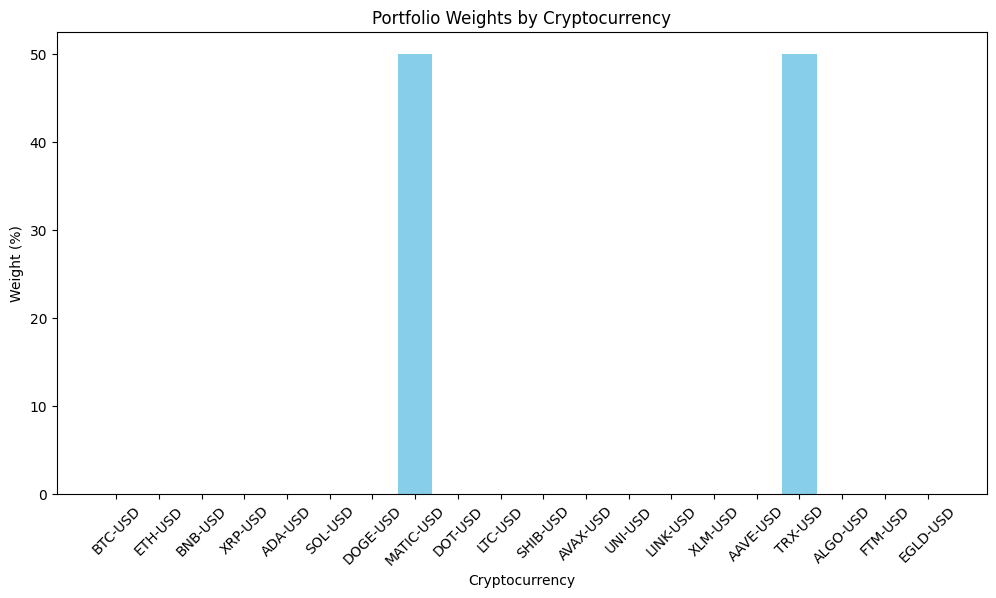

In [52]:
# Бар-графік ваг
plt.figure(figsize=(12, 6))
plt.bar(optimal_portfolio['Ticker'], optimal_portfolio['Weight (%)'], color='skyblue')
plt.title('Portfolio Weights by Cryptocurrency')
plt.xlabel('Cryptocurrency')
plt.ylabel('Weight (%)')
plt.xticks(rotation=45)
plt.show()


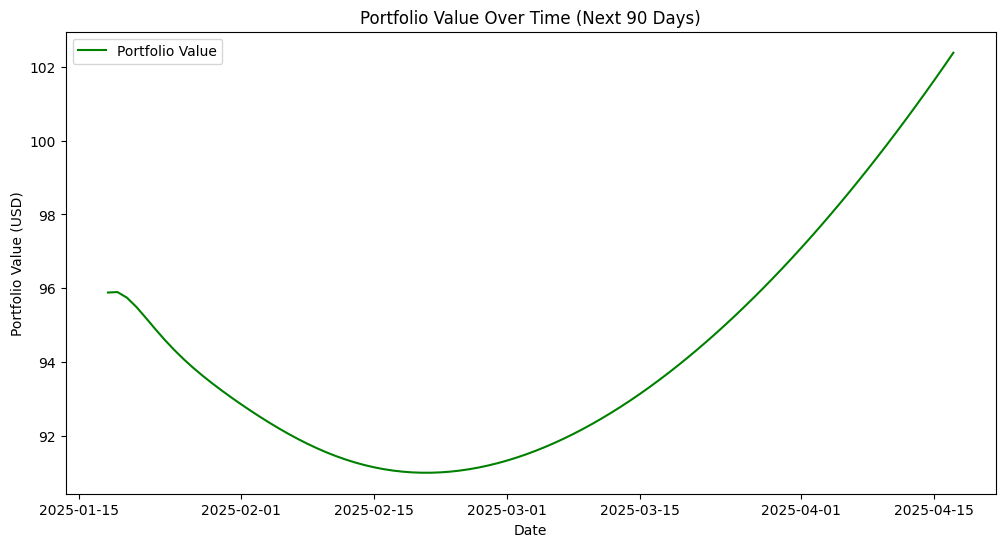

In [53]:
# Розрахунок загальної прогнозованої вартості портфеля
portfolio_value = np.zeros(90)  # На 90 днів вперед
for i, ticker in enumerate(tickers):
    portfolio_value += future_prices[ticker] * optimal_weights[i]

# Графік вартості портфеля
future_dates = pd.date_range(datetime.today(), periods=90)
plt.figure(figsize=(12, 6))
plt.plot(future_dates, portfolio_value, label='Portfolio Value', color='green')
plt.title('Portfolio Value Over Time (Next 90 Days)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.show()


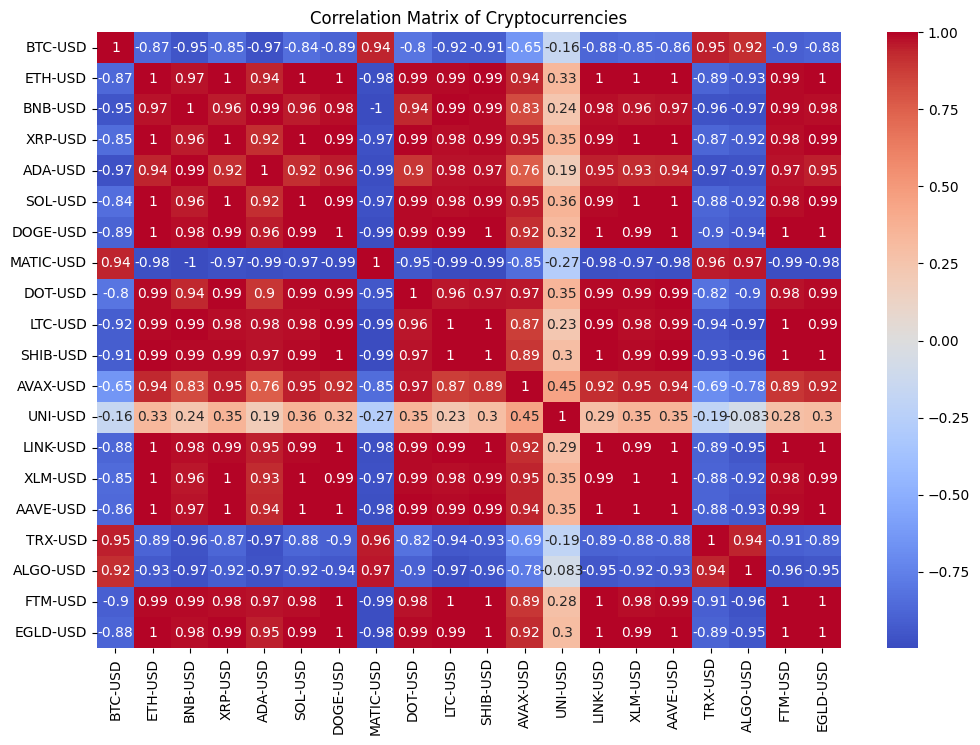

In [54]:
import seaborn as sns

# Розрахунок кореляцій
closing_prices = pd.DataFrame({ticker: future_prices[ticker] for ticker in tickers})
correlation_matrix = closing_prices.corr()

# Теплова карта
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Cryptocurrencies')
plt.show()


In [61]:
# Зняття обмежень
constraints = [cp.sum(weights) == 1, weights >= 0]  # Без обмеження <= 0.5

# Оптимізація
weights = cp.Variable(len(tickers))
risk = cp.quad_form(weights, cov_matrix)
objective = cp.Maximize(returns @ weights - 0.5 * risk)
problem = cp.Problem(objective, constraints)
problem.solve()

# Перевірка результатів
print("Optimal Weights:", weights.value)
print("Sum of Weights:", np.sum(weights.value))





Optimal Weights: None
Sum of Weights: None


TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable sqrt method

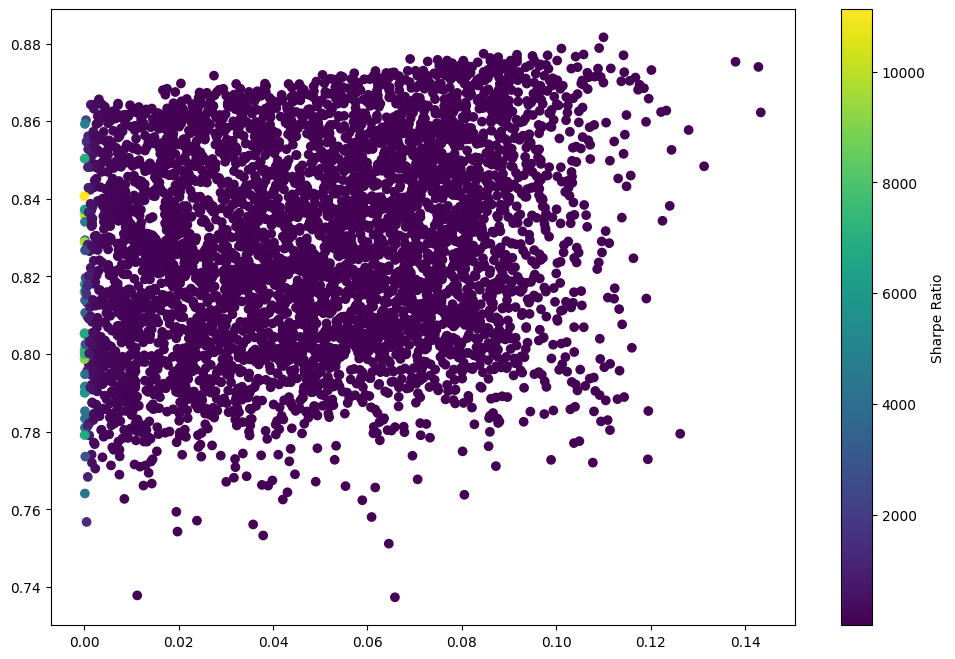

In [64]:
# Масштабування returns
returns = np.array(list(expected_returns.values())).flatten()
returns = (returns - np.min(returns)) / (np.max(returns) - np.min(returns))  # Приводимо до діапазону [0, 1]

# Масштабування коваріаційної матриці
cov_matrix = (cov_matrix + cov_matrix.T) / 2  # Симетризація
eigenvalues = np.linalg.eigvals(cov_matrix)
if np.any(eigenvalues < 0):  # Виправлення, якщо є від’ємні значення
    cov_matrix += np.eye(len(cov_matrix)) * abs(np.min(eigenvalues)) * 1.01
cov_matrix /= np.max(np.abs(cov_matrix))  # Нормалізація

# Генерація випадкових портфелів
num_portfolios = 5000
results = np.zeros((3, num_portfolios))  # Очікувана дохідність, ризик, Sharpe ratio

for i in range(num_portfolios):
    random_weights = np.random.random(len(tickers))
    random_weights /= np.sum(random_weights)
    portfolio_return = np.dot(random_weights, returns)
    portfolio_risk = np.sqrt(np.dot(random_weights.T, np.dot(cov_matrix, random_weights)))
    if portfolio_risk <= 0:  # Захист від ділення на нуль
        portfolio_risk = 1e-6
    sharpe_ratio = portfolio_return / portfolio_risk
    results[0, i] = portfolio_return
    results[1, i] = portfolio_risk
    results[2, i] = sharpe_ratio

# Побудова графіка
plt.figure(figsize=(12, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(np.sqrt(risk.value), np.dot(optimal_weights, returns), color='red', label='Optimal Portfolio', s=100)
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.show()
